## Neural network classification


### 1. Make classification and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# Create circle
X, y = make_circles(n_samples=1000, # make 1000 samples
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:
# Make Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


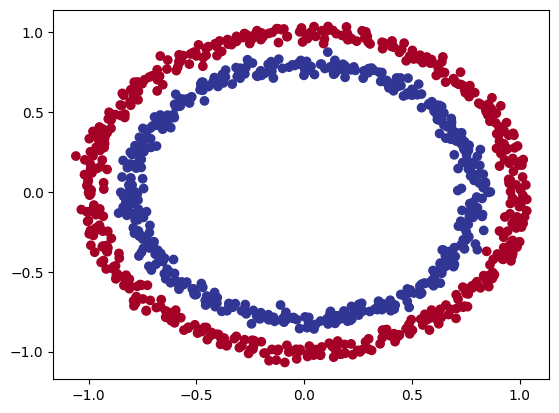

In [ ]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c = y,
            cmap=plt.cm.RdYlBu);

Note: The data is often referred to as toy dataset, small to experiment but sizeable to practice

### Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Values for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Values for one sample of X: (2,) and the same for y: ()


### Turn data into tensor and create train and test splits

In [ ]:
# Turn data to tensor
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,# 0.2 = 20% for test 80% for train
                                                   random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

We need to:
1. Setup device agnostic code so our code will run on accelerator (GPU) if available
2. Construc a model (subclass nn.module)
3. Define a loss function and optimizer
4. Create training and loop


In [ ]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Create a model that:
1. Subclasses nn.module
2. Create 2 nn.Linear() layers that are capable of handling shapes of our data
3. Define a forward() method that outline the forward pass or forward computation of model
4. Instantiate an instance of our model class and send it to the target device

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
# 1. Construct model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linearlayer capable of handling shape of our data
    self.layer_1 = nn.Linear(in_features=2, # takes in 2 features and upscale to 5 features
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5, # must be same as previous out and output a sinlge features (same shape as y)
                             out_features=1)

    # 3. Define a forward method
    def forward(self, X):
      return self.layer_2(self.layer_1(X)) # X -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Replicate model using nn.Sequential()\
model_0 = nn.Sequential(
    nn.Linear(in_features= 2, out_features= 5),
    nn.ReLU(),
    nn.Linear(in_features= 5, out_features= 10),
    nn.ReLU(),
    nn.Linear(in_features= 10, out_features= 15),
    nn.ReLU(),
    nn.Linear(in_features= 15, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=15, bias=True)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6320, -0.2613],
                      [-0.0877, -0.6366],
                      [ 0.4727,  0.2289],
                      [ 0.6268,  0.3204],
                      [ 0.1193, -0.7064]])),
             ('0.bias', tensor([-0.2561, -0.4697, -0.1696, -0.5192, -0.6429])),
             ('2.weight',
              tensor([[ 0.1730, -0.1149, -0.4204, -0.1673,  0.1897],
                      [ 0.3014, -0.2804, -0.3401, -0.0856,  0.0095],
                      [ 0.2034,  0.0236, -0.2835, -0.0172, -0.1291],
                      [ 0.1081, -0.2754, -0.2445, -0.1927, -0.3946],
                      [-0.1765, -0.4069, -0.0520, -0.1707,  0.0325],
                      [ 0.2410, -0.3928,  0.2403, -0.1297, -0.1086],
                      [ 0.1812, -0.2038, -0.3934,  0.1202,  0.4148],
                      [-0.2464,  0.2974, -0.0299, -0.4421, -0.4075],
                      [ 0.0853, -0.0086, -0.3023,  0.0963, -0.3212],
                      [ 0.4462,  0

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\n First 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

 First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

### 2.1 Setup loss function and optimizer

For regresssion : MAE or MSE
For classification : binary cross entroy or cross entopy

loss funtion : measure how wrong model prediction are
* Loss function use BECWithLogitsLoss()

optimizers : most common are SGD and Adam


In [ ]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation built in

optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr = 0.1)

In [ ]:
# Calculate accuracy : out of 100 examples, what percentage does our model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


## 3. Train model
Make training loop:
1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step

### 3.1 Going from raw logits --> prediction probabilities -> predictions label
Our model output going to be raw logits

we can convert logits to predictions probabilities by passing them to some kind of activation funtion

Then we can convert our model prediction probabilities to prediction labels by either rounding them or taking the argmax()

In [ ]:
# View the first 5 output of forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5] # logits = raw output of our model without passing to any activating function
y_logits


tensor([[0.1078],
        [0.1088],
        [0.1078],
        [0.1078],
        [0.1034]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits to turn the into prediction probability
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5269],
        [0.5272],
        [0.5269],
        [0.5269],
        [0.5258]])

For prediction probability values, we need to perform a range-style rounding on them:
* y_pred_probs >= 0.5, y = 1 (class 1)
* y_preds_probs < 0.5, y = 0 (class 0)

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_preds_probs)

# In full (logits -> pred probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

### Build training and test loop

In [ ]:
epochs = 1000
torch.manual_seed(42)

# Put data to target device
X_train, y_train, = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  # training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred lables

  # 2. Calculate loss / accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                  y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing

  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} |, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69391, Acc: 50.00% | Test loss: 0.69383 |, Test acc: 50.00%
Epoch: 10 | Loss: 0.69309, Acc: 50.00% | Test loss: 0.69307 |, Test acc: 50.00%
Epoch: 20 | Loss: 0.69270, Acc: 50.00% | Test loss: 0.69270 |, Test acc: 50.00%
Epoch: 30 | Loss: 0.69249, Acc: 50.00% | Test loss: 0.69250 |, Test acc: 50.00%
Epoch: 40 | Loss: 0.69237, Acc: 50.00% | Test loss: 0.69238 |, Test acc: 50.00%
Epoch: 50 | Loss: 0.69228, Acc: 50.00% | Test loss: 0.69229 |, Test acc: 50.00%
Epoch: 60 | Loss: 0.69221, Acc: 60.12% | Test loss: 0.69221 |, Test acc: 58.00%
Epoch: 70 | Loss: 0.69214, Acc: 67.75% | Test loss: 0.69214 |, Test acc: 64.50%
Epoch: 80 | Loss: 0.69207, Acc: 66.25% | Test loss: 0.69207 |, Test acc: 66.00%
Epoch: 90 | Loss: 0.69200, Acc: 64.50% | Test loss: 0.69200 |, Test acc: 64.50%
Epoch: 100 | Loss: 0.69193, Acc: 63.38% | Test loss: 0.69192 |, Test acc: 62.50%
Epoch: 110 | Loss: 0.69185, Acc: 62.75% | Test loss: 0.69185 |, Test acc: 62.00%
Epoch: 120 | Loss: 0.69178, Acc: 61.38%

## 4. Make predictions and evaluate the model

From the metrics it looks like model isnt learning anything

To inspect makes predictions and make visual

To do so, import plot_decision_boundary()

In [ ]:
import requests
from pathlib import Path
# Download helper functions from learn pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist")
else:
  print("Download helper_funtions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_funtions.py


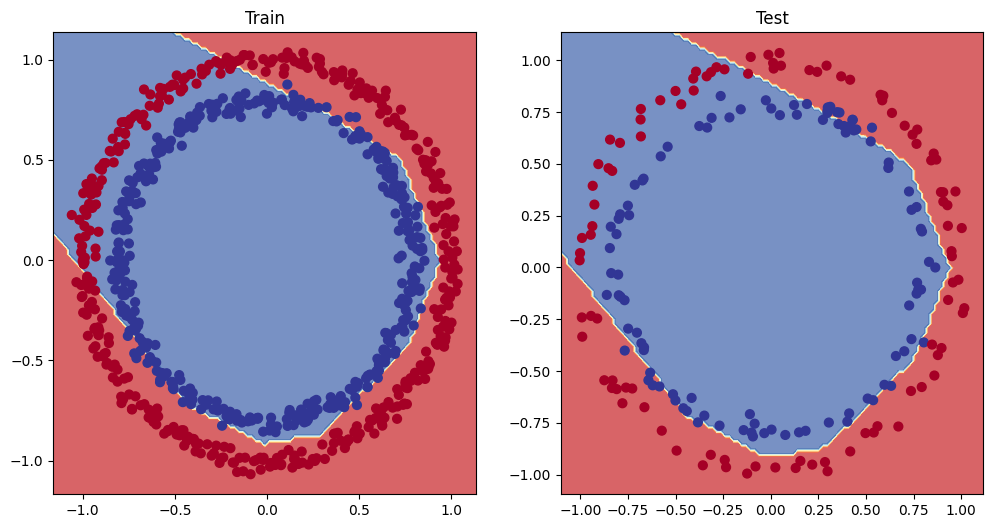

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2) # Row, column, index
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving a model (from model perspective)

* Add more layer - give model chaces to learn about patterns in data
* Add more hidden units - from 5 to 10 hidden units
* Fit for longer
* Changing the activation fuctions
* Change the learning rate
* Change the loss functions

These option are all from model prespective becasue they deal direcly with model

Because these options are all values we can change, they are called hyperparameter

Improve model:
* Adding more hidden units 5 -> 10
* Increase the number of layer 2 -> 3
* Increase the number of epochs 100 -> 1000

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features= 10, out_features= 10)
    self.layer_3 = nn.Linear(in_features= 10, out_features= 1)

  def forward(self, x ) :
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this of way of writing operations leverages the speed up where possible behind the scene

model_1 = CircleModelV0().to(device)
model_1

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 1.0765, -0.5593],
                      [-0.9524, -0.7994],
                      [ 0.4693,  0.1970],
                      [ 0.5677,  1.1671],
                      [ 0.2357, -1.0310]])),
             ('0.bias', tensor([-0.4980, -0.4182, -0.2911, -0.5290, -0.6346])),
             ('2.weight',
              tensor([[ 0.0157, -0.2863, -0.4490, -0.2367,  0.0632],
                      [ 0.3014, -0.2804, -0.3401, -0.0856,  0.0095],
                      [ 0.2034,  0.0236, -0.2835, -0.0172, -0.1291],
                      [-0.4497, -0.6867, -0.4796, -0.6767, -0.7085],
                      [-0.1765, -0.4069, -0.0520, -0.1707,  0.0325],
                      [ 0.2410, -0.3928,  0.2403, -0.1297, -0.1086],
                      [ 0.1812, -0.2038, -0.3934,  0.1202,  0.4148],
                      [-0.4899, -0.0127, -0.0935, -0.6054, -0.6288],
                      [ 0.1637,  0.0708, -0.2631,  0.1491, -0.2690],
                      [ 1.0131,  0

In [ ]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [ ]:
# Create a loss functions
loss = nn.BCEWithLogitsLoss()


# Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)


In [ ]:
print(X_train.dtype)

torch.float32


In [ ]:
# Write training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  # Train mode
  model_1.train()
  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)

  #Optimizer zero grad
  optimizer.zero_grad()

  # Backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, ACC: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69396, ACC: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, ACC: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, ACC: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, ACC: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, ACC: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, ACC: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, ACC: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, ACC: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, ACC: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, ACC: 51.00% | Test loss: 0.69468, Test acc: 46.00%


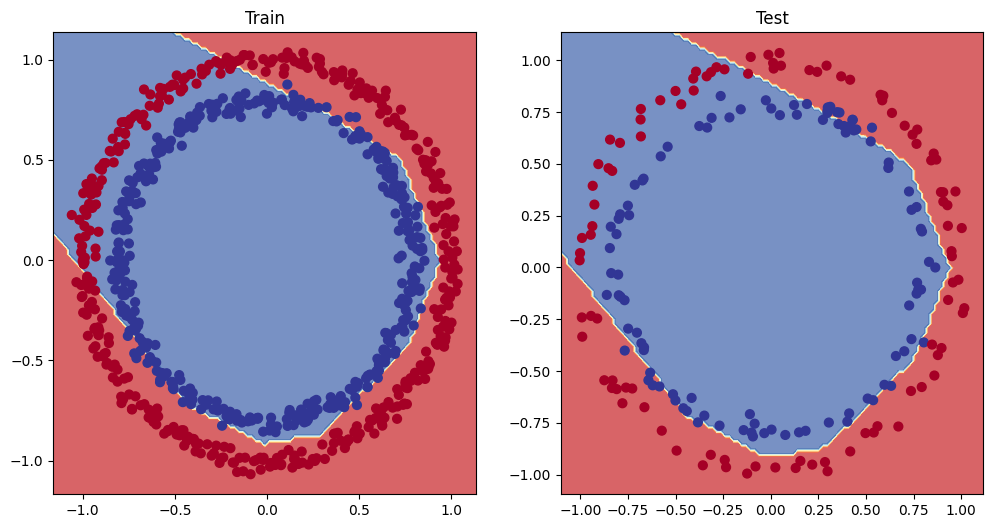

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2) # Row, column, index
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


### 5.1 Preparing data to see if out model can fit a straight line

Test by using previous worked model

In [ ]:
# Create small data (previous learn)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)


(80, 20, 80, 20)

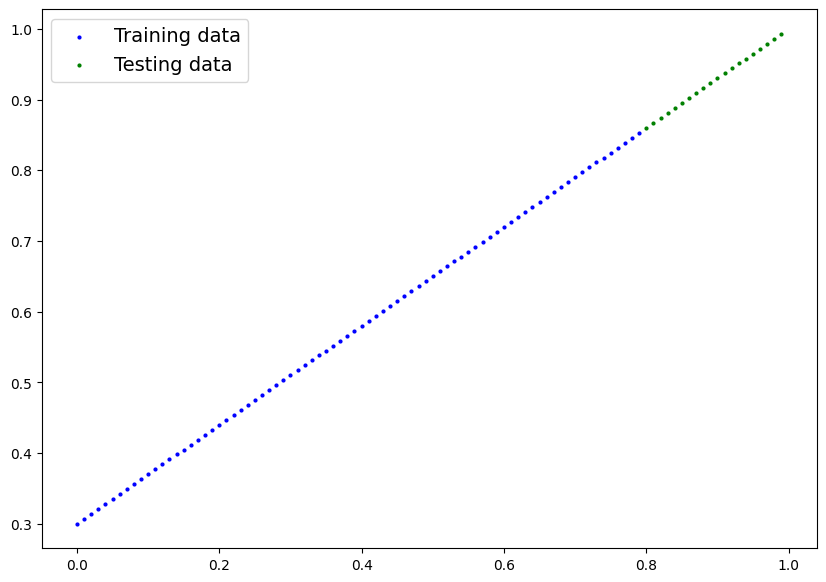

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

In [ ]:
### 5.2 Adjusting model_1 to fit a straight line
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)



In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Train
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

    # Print out
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test_loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test_loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test_loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test_loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test_loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test_loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test_loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test_loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test_loss: 0.02127
Epoch: 800 | Loss: 0.05600 | Test_loss: 0.01425
Epoch: 900 | Loss: 0.05571 | Test_loss: 0.00603


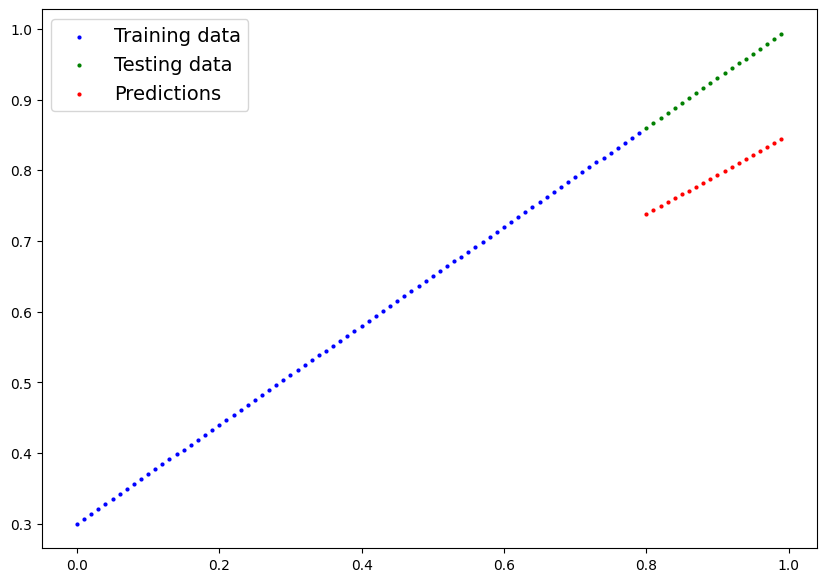

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

  #plot data
  plot_predictions(train_data=X_train_regression.cpu(),
                   train_labels= y_train_regression.cpu(),
                   test_data = X_test_regression.cpu(),
                   test_labels = y_test_regression.cpu(),
                   predictions = y_preds.cpu());


## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circle)

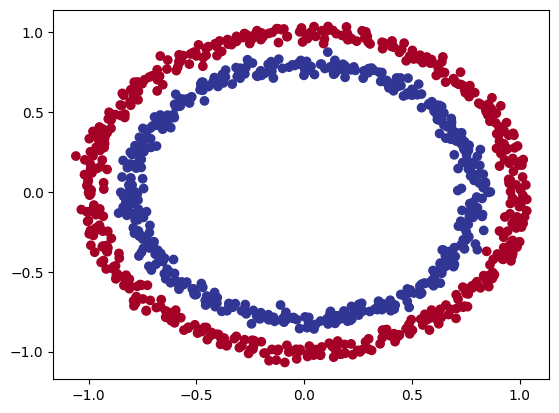

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_sparse_coded_signal
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap=plt.cm.RdYlBu )

In [ ]:
# Convert data to tensors then train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building model with non-linearity

* Linear = straight linear
* Non-linear = not straight line

Artificial neural networks are a large combination of linear and non straight function

In [ ]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                            out_features= 10)
    self.layer_2 = nn.Linear(in_features=10,
                            out_features= 10)
    self.layer_3 = nn.Linear(in_features=10,
                            out_features= 1)
    self.relu = nn.ReLU()


  def forward (self, x):
      # Where should we put or non-linear activation functions?
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
      # relu in between each layer

model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_3.parameters(),
                             lr=0.1)


### 6.3 Training a model with non-linearity

In [ ]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()

  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits )) # logits -> prediction probabilites ->

  # Calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # optim zero grad
  optimizer.zero_grad()

  # Loss back
  loss.backward()

  # Step optim
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f} , Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929 , Acc: 50.00% | Test loss: 0.6939, Test Acc: 50.00%
Epoch: 100 | Loss: 0.0017 , Acc: 100.00% | Test loss: 0.0074, Test Acc: 100.00%
Epoch: 200 | Loss: 0.0007 , Acc: 100.00% | Test loss: 0.0054, Test Acc: 100.00%
Epoch: 300 | Loss: 0.0004 , Acc: 100.00% | Test loss: 0.0049, Test Acc: 100.00%
Epoch: 400 | Loss: 0.0003 , Acc: 100.00% | Test loss: 0.0057, Test Acc: 100.00%
Epoch: 500 | Loss: 0.0002 , Acc: 100.00% | Test loss: 0.0052, Test Acc: 100.00%
Epoch: 600 | Loss: 0.0001 , Acc: 100.00% | Test loss: 0.0051, Test Acc: 100.00%
Epoch: 700 | Loss: 0.0001 , Acc: 100.00% | Test loss: 0.0053, Test Acc: 100.00%
Epoch: 800 | Loss: 0.0001 , Acc: 100.00% | Test loss: 0.0056, Test Acc: 100.00%
Epoch: 900 | Loss: 0.0001 , Acc: 100.00% | Test loss: 0.0058, Test Acc: 100.00%


### 6.4 Evaluating model trained with non-linear activation functions

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10],y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

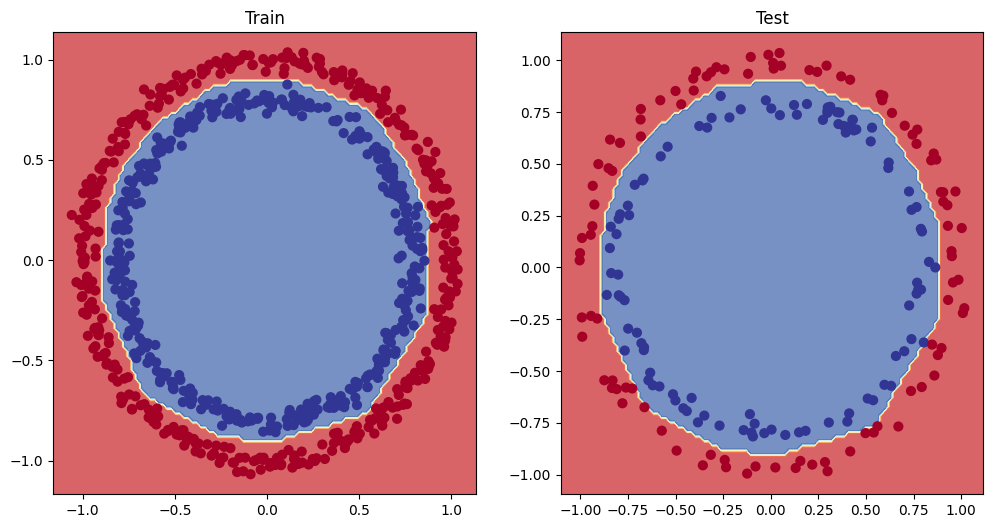

In [ ]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than ustelling the model what to learn, we give it the tools to discover patterns in data and patterns on its own

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

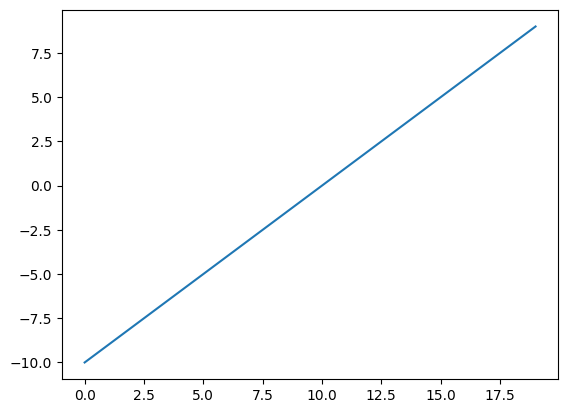

In [ ]:
# Visualize tensor
plt.plot(A);

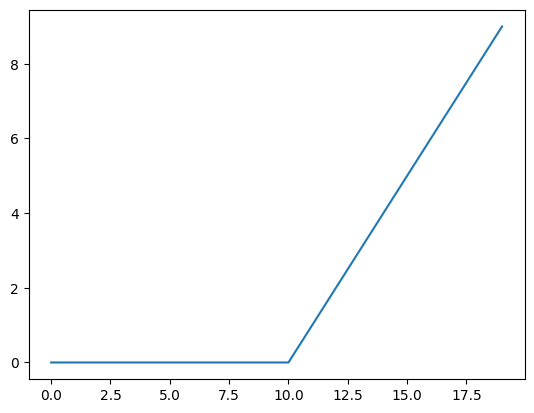

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)
# Take the maximum from 0 to x so unless its higher than 0 it will go to 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

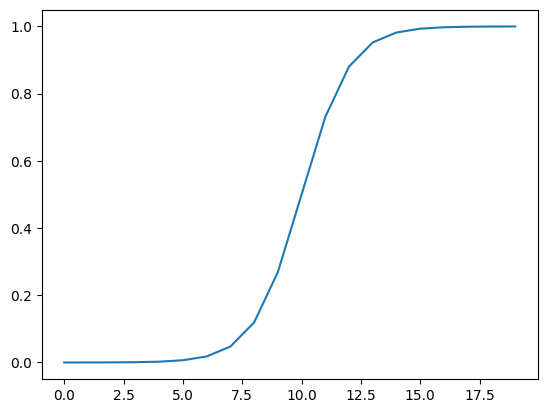

In [ ]:
# Now lets do the same for sigmoid
def sigmoid(x):
  return 1/ (1 + torch.exp(-x))

plt.plot(torch.sigmoid(A))

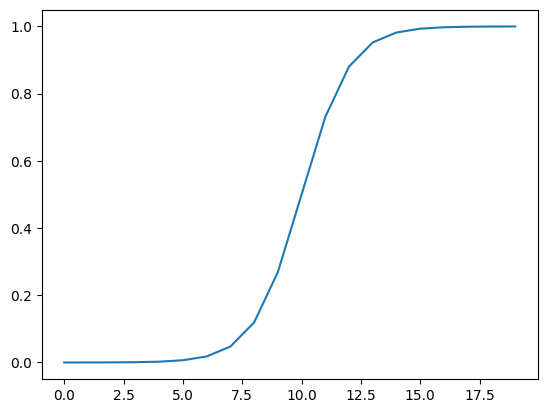

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification proble

* Binary classification = one thing or another (Cat vs dog, spam or not, fraud or not)
* Multi-class classification = more than one thing or another (dog vs cat vs bird)

### 8.1 Creating a toy multi-class dataset

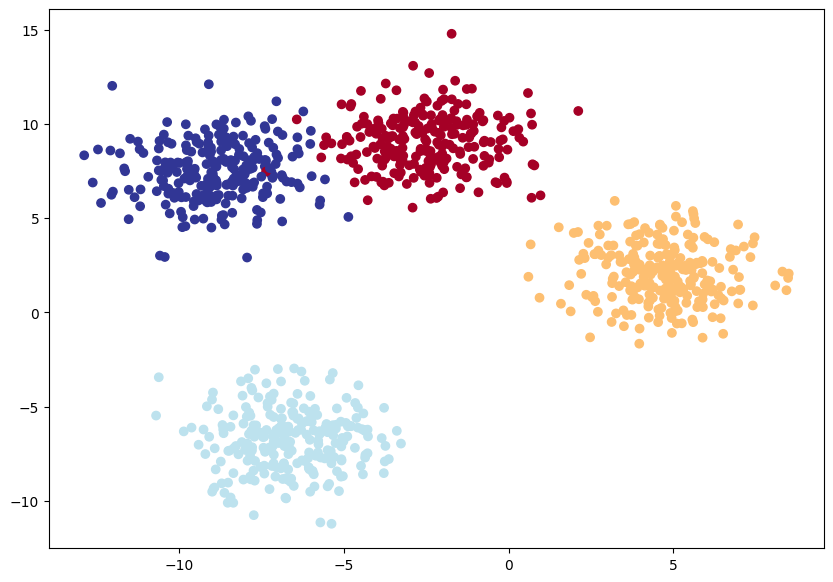

In [2]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, #give the cluster a bit harder
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Making the model

In [3]:
# 4 class so 4 output features
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Build a multi class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initialization multi-class classification model.
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Examples:
    """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of blob model and send it to target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

NameError: name 'nn' is not defined

In [ ]:
X_blob_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and optimizer

In order to evaluate and train and test model, we need to convert model output (logits) to prediction probabilities and then to prediction lables


logits (raw output of the model) -> pred probs (use rorch.softmax) -> pred lables (take the argmax of the prediction probabilities)

In [ ]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a mult-class pytorch model

In [ ]:
# Raw output of our model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_preds[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

In [ ]:
# Convert model logits output to preds probs
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [ ]:
# Convert our model prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Training the multi-class models

In [ ]:
y_blob_train.dtype

torch.int64

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.sigmoid(y_logits).round()

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true= y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true= y_blob_test,
                           y_pred=test_preds)

  # Printout
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% |Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")

Epoch: 0 | Loss: 1.0432, Acc: 65.50% |Test loss: 0.5786, Test acc:95.50%
Epoch: 10 | Loss: 0.1440, Acc: 99.12% |Test loss: 0.1304, Test acc:99.00%
Epoch: 20 | Loss: 0.0806, Acc: 99.12% |Test loss: 0.0722, Test acc:99.50%
Epoch: 30 | Loss: 0.0592, Acc: 99.12% |Test loss: 0.0513, Test acc:99.50%
Epoch: 40 | Loss: 0.0489, Acc: 99.00% |Test loss: 0.0410, Test acc:99.50%
Epoch: 50 | Loss: 0.0429, Acc: 99.00% |Test loss: 0.0349, Test acc:99.50%
Epoch: 60 | Loss: 0.0391, Acc: 99.00% |Test loss: 0.0308, Test acc:99.50%
Epoch: 70 | Loss: 0.0364, Acc: 99.00% |Test loss: 0.0280, Test acc:99.50%
Epoch: 80 | Loss: 0.0345, Acc: 99.00% |Test loss: 0.0259, Test acc:99.50%
Epoch: 90 | Loss: 0.0330, Acc: 99.12% |Test loss: 0.0242, Test acc:99.50%


### 8.6 Making and evaluating predictions with a pytorch multi-class model

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

  # view the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [ ]:
# Go from logits -> prediction probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4332e-03, 9.9757e-01, 1.0804e-11, 1.8271e-09],
        [3.4828e-03, 1.3697e-10, 6.8363e-04, 9.9583e-01],
        [2.8657e-12, 1.2266e-15, 9.9973e-01, 2.6959e-04],
        [3.2692e-03, 9.9673e-01, 9.5435e-08, 4.7619e-07],
        [9.9168e-01, 8.3089e-03, 1.4120e-10, 8.2969e-06],
        [4.5039e-04, 5.4287e-13, 2.5532e-04, 9.9929e-01],
        [1.6306e-11, 2.4030e-13, 9.9987e-01, 1.3003e-04],
        [9.9860e-01, 3.9485e-04, 5.9937e-08, 1.0045e-03],
        [3.0436e-14, 6.8303e-20, 9.9965e-01, 3.5218e-04],
        [9.9843e-01, 1.3657e-03, 9.0767e-09, 2.0006e-04]])

In [ ]:
# Go from preb prob -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

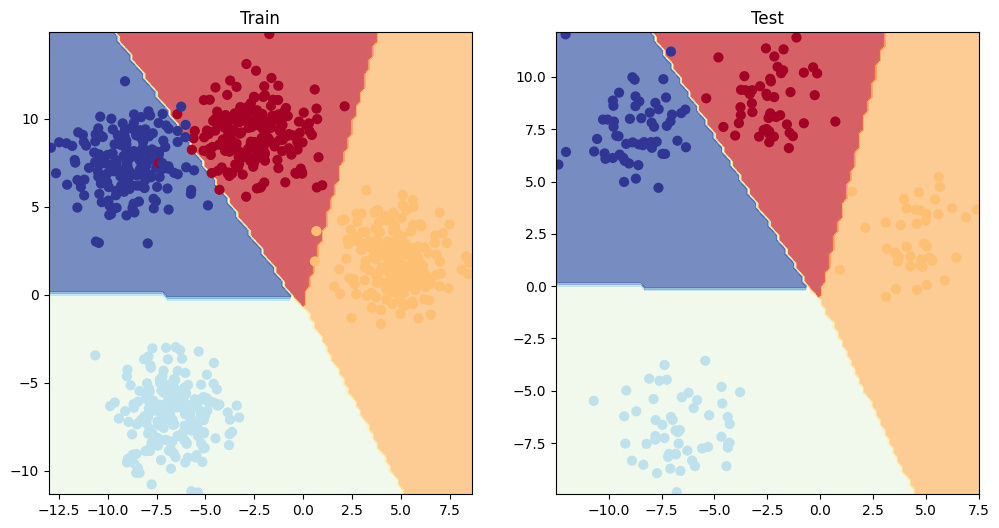

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. Few more classification metrics (to evaluate our classification metrics)

* Accuracy - out of 100 sample how many get right
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report



In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 777.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)
print(f"Accuracy:{acc}%")

Accuracy:99.125%


## 10. Self Learn



### Step 1

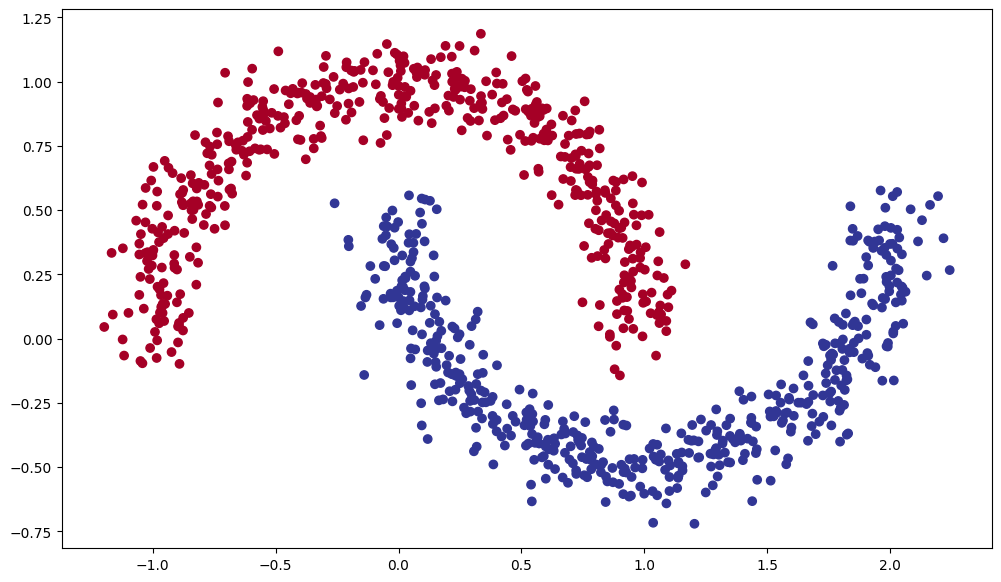

In [ ]:
## Make binary classification
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch import nn
from torchmetrics import Accuracy

NUM_CLASSES = 2
NUM_FEATURES = 2
RANDOM_SEED = 42

X_moons, y_moons = make_moons(n_samples=1000,
                            noise=0.09,
                            random_state=RANDOM_SEED)

X_moons = torch.from_numpy(X_moons).type(torch.float)
y_moons = torch.from_numpy(y_moons).type(torch.LongTensor)

# Split into train and test
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons,
                                                                            y_moons,
                                                                            test_size = 0.2,
                                                                            random_state =RANDOM_SEED)

# Plot the data
plt.figure(figsize=(12,7))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.RdYlBu);

### Step 2

In [ ]:
## Build the model
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class MoonModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_5 = MoonModel(input_features=2,
                    output_features=2,
                    hidden_units=8).to(device)

model_5


MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

### Step 3

In [ ]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
optimizer = torch.optim.SGD(params=model_5.parameters(),
                            lr=0.1)

### Step 4

In [ ]:
# Create a training and testing loop
model_5.eval()
with torch.inference_mode():
  y_logits = model_5(X_moons_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds
acc_fn

tensor([[ 0.0026, -0.5419],
        [-0.1247, -0.6042],
        [-0.0957, -0.5851],
        [-0.1001, -0.6362],
        [-0.1963, -0.6233]])
tensor([[0.6328, 0.3672],
        [0.6176, 0.3824],
        [0.6200, 0.3800],
        [0.6309, 0.3691],
        [0.6052, 0.3948]])


MulticlassAccuracy()

### Step 5

In [ ]:
torch.manual_seed(RANDOM_SEED)
epochs = 1000

for epoch in range(epochs):
    model_5.train()

    y_logits = model_5(X_moons_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_moons_train)
    train_acc = acc_fn(y_pred, y_moons_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_5.eval()
    with torch.inference_mode():
        test_logits = model_5(X_moons_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_moons_test)
        test_acc = acc_fn(test_pred, y_moons_test)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")


Epoch 0 | Loss: 0.7132 | Train Acc: 0.50 | Test Loss: 0.7052 | Test Acc: 0.50
Epoch 100 | Loss: 0.2947 | Train Acc: 0.86 | Test Loss: 0.3019 | Test Acc: 0.85
Epoch 200 | Loss: 0.2497 | Train Acc: 0.88 | Test Loss: 0.2438 | Test Acc: 0.88
Epoch 300 | Loss: 0.2396 | Train Acc: 0.88 | Test Loss: 0.2306 | Test Acc: 0.90
Epoch 400 | Loss: 0.2334 | Train Acc: 0.88 | Test Loss: 0.2236 | Test Acc: 0.90
Epoch 500 | Loss: 0.2280 | Train Acc: 0.88 | Test Loss: 0.2174 | Test Acc: 0.90
Epoch 600 | Loss: 0.2230 | Train Acc: 0.88 | Test Loss: 0.2119 | Test Acc: 0.90
Epoch 700 | Loss: 0.2050 | Train Acc: 0.91 | Test Loss: 0.1910 | Test Acc: 0.92
Epoch 800 | Loss: 0.1440 | Train Acc: 0.94 | Test Loss: 0.1305 | Test Acc: 0.95
Epoch 900 | Loss: 0.0915 | Train Acc: 0.97 | Test Loss: 0.0792 | Test Acc: 0.99


### Step 6

In [ ]:
# Make prediction with trained model
def plot_decision_boundary(model, X, y):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Reduce logits to class predictions
    if y_logits.shape[1] > 1:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    # Reshape to match mesh grid
    y_pred = y_pred.reshape(xx.shape).detach().numpy()

    # Plotting
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


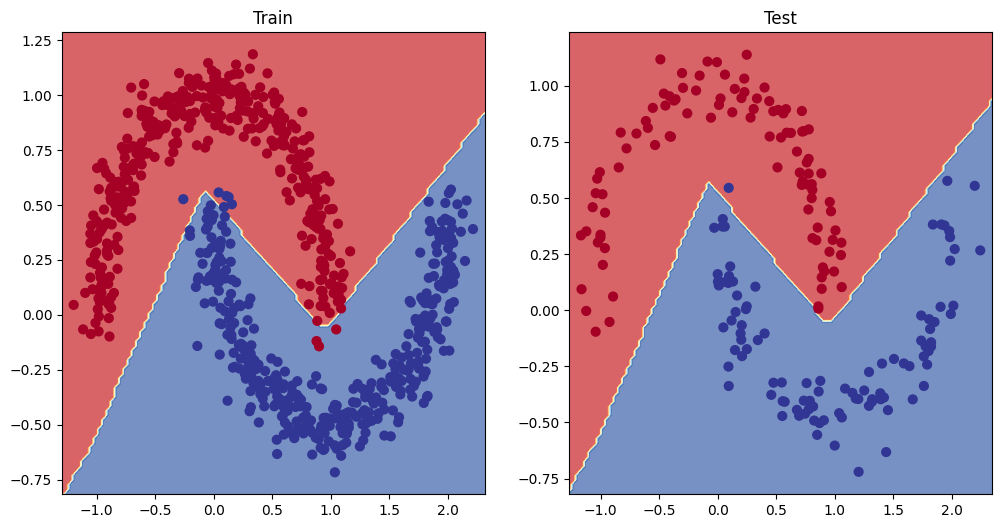

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_5, X_moons_train, y_moons_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_5, X_moons_test, y_moons_test)
plt.show()

### Step 1 again

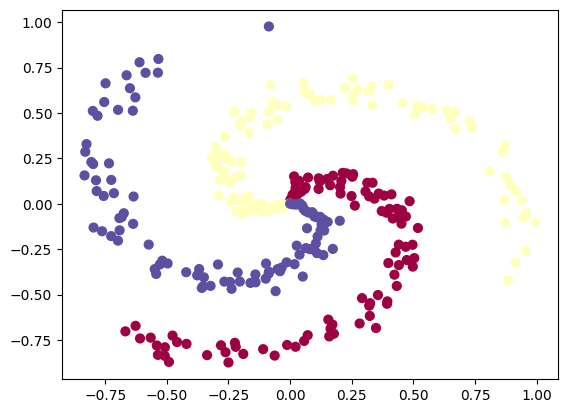

In [ ]:
# Wow spiral data sets
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()